---

# Part 2: Predict the priority of a tweet post to feed it at the right time to the right emergency officier

---

### **0 - Merge the graph**

In [1]:
import pandas as pd
import json

# -------------------
# Load all nodes
# -------------------

def load_nodes(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            obj = json.loads(line.strip())
            node = obj['n']
            node['properties']['type'] = node['labels'][0]
            node['properties']['node_id'] = node['id']
            data.append(node['properties'])
    return pd.DataFrame(data)

# -------------------
# Load all relationships
# -------------------

def load_relationships(file_path):
    relations = []
    with open(file_path, 'r') as f:
        for line in f:
            obj = json.loads(line.strip())
            r = obj['r']
            relations.append({
                'rel_id': r['id'],
                'type': r['label'],
                'start_id': r['start']['id'],
                'start_label': r['start']['labels'][0],
                'end_id': r['end']['id'],
                'end_label': r['end']['labels'][0]
            })
    return pd.DataFrame(relations)

# -------------------
# Example merging workflow
# -------------------

# Load nodes
tweets = load_nodes('data/database/Nodes/Tweet.json')
users = load_nodes('data/database/Nodes/User.json')
hashtags = load_nodes('data/database/Nodes/Hashtag.json')
events = load_nodes('data/database/Nodes/Event.json')
categories = load_nodes('data/database/Nodes/PostCategory.json')

# Load relationships
has_category = load_relationships('data/database/Relationships/HAS_CATEGORY.json')
has_hashtag = load_relationships('data/database/Relationships/HAS_HASHTAG.json')
is_about = load_relationships('data/database/Relationships/IS_ABOUT.json')
mentions = load_relationships('data/database/Relationships/MENTIONS.json')
posted = load_relationships('data/database/Relationships/POSTED.json')

# -------------------
# Merge Tweet + PostCategory
# -------------------
has_category = has_category.merge(categories, left_on='end_id', right_on='node_id', how='left')
has_category = has_category.rename(columns={'id': 'category'})
tweets = tweets.merge(has_category[['start_id', 'category']], left_on='node_id', right_on='start_id', how='left')

# -------------------
# Merge Tweet + Hashtags
# -------------------
has_hashtag = has_hashtag.merge(hashtags, left_on='end_id', right_on='node_id', how='left')
has_hashtag_grouped = has_hashtag.groupby('start_id')['id'].apply(list).reset_index(name='hashtags')
tweets = tweets.merge(has_hashtag_grouped, left_on='node_id', right_on='start_id', how='left')

# -------------------
# Merge Tweet + Event (IS_ABOUT)
# -------------------
is_about = is_about.merge(events, left_on='end_id', right_on='node_id', how='left')
is_about = is_about.rename(columns={'id': 'event_id', 'eventType': 'event_type'})
tweets = tweets.merge(is_about[['start_id', 'event_id', 'event_type']], left_on='node_id', right_on='start_id', how='left')

# -------------------
# Merge Tweet + User (POSTED)
# -------------------
posted = posted.merge(users, left_on='start_id', right_on='node_id', how='left')
posted = posted.rename(columns={'screen_name': 'author'})
tweets = tweets.merge(posted[['end_id', 'author', 'followers_count', 'friends_count']], left_on='node_id', right_on='end_id', how='left')

In [2]:
tweets.head(5)

,isTruncated,possibly_sensitive,created_at,retweet_count,annotation_annotated,is_quote_status,annotation_num_judgements,annotation_postPriority,id_str,topic,...,category,start_id_y,hashtags,start_id,event_id,event_type,end_id,author,followers_count,friends_count
0,False,False,2012-06-09T00:00Z,0,True,False,3,Low,211281973870727170,TRECIS-CTIT-H-001,...,Irrelevant,582,"[amazing, colorado]",582,fireColorado2012,wildfire,582,jeffseroka,537,400
1,False,False,2012-06-09T00:00Z,3,True,False,1,Medium,211557401231495171,TRECIS-CTIT-H-001,...,FirstPartyObservation,583,[HighParkFire],583,fireColorado2012,wildfire,583,mpf2011,4740,4930
2,False,True,2012-06-09T00:00Z,2,True,False,1,High,211565974422425600,TRECIS-CTIT-H-001,...,ServiceAvailable,584,"[Colorado, Evacuation, Wildfire]",584,fireColorado2012,wildfire,584,SF_AngelaThorpe,2684,4726
3,False,True,2012-06-09T00:00Z,0,True,False,1,Medium,211607187653533697,TRECIS-CTIT-H-001,...,Weather,585,"[Colorado, Heat, HighParkFire, COwx, Coolbreak]",585,fireColorado2012,wildfire,585,WilliamScherer3,113859,104963
4,False,False,2012-06-10T00:00Z,0,True,False,1,Medium,211654415503990784,TRECIS-CTIT-H-001,...,News,586,[HighParkFire],586,fireColorado2012,wildfire,586,sherivf,1624,1849


In [3]:
tweets.shape

(115950, 26)

### **1 - Split data into training and testing subsets**

In [4]:
tweets['annotation_postPriority'].value_counts()

annotation_postPriority
Low         55361
Medium      23756
Unknown     19325
High        15186
Critical     2322
Name: count, dtype: int64

We delete the tweets with **Unknown** value, and consider **Critical** and **High** as the same category.

In [5]:
# Display the count of NaNs for each column
print("Missing values per column:")
print(tweets.isna().sum())

Missing values per column:
isTruncated                      0
possibly_sensitive               0
created_at                       0
retweet_count                    0
annotation_annotated             0
is_quote_status                  0
annotation_num_judgements        0
annotation_postPriority          0
id_str                        6129
topic                            0
favorite_count                   0
id                               0
text                             0
type                             0
node_id                          0
start_id_x                   19375
category                     19375
start_id_y                   50282
hashtags                     50282
start_id                     19321
event_id                     19321
event_type                   19321
end_id                           0
author                           0
followers_count                  0
friends_count                    0
dtype: int64


In [6]:
tweets['id'].value_counts()

id
1131991143770656768    16
1131653559743725568    16
1131999237875519488    15
1131953405025562625    15
1132002803960885248    14
                       ..
593260773612224512      1
593261661546487808      1
593258734505349121      1
593265553441099777      1
727643060360749056      1
Name: count, Length: 55986, dtype: int64

In [7]:
df_id = tweets[tweets['id'] == 1131991143770656768]

In [8]:
df_id

,isTruncated,possibly_sensitive,created_at,retweet_count,annotation_annotated,is_quote_status,annotation_num_judgements,annotation_postPriority,id_str,topic,...,category,start_id_y,hashtags,start_id,event_id,event_type,end_id,author,followers_count,friends_count
72683,False,False,2019-05-24T00:00Z,4,True,False,3,High,1131991143770656768,TRECIS-CTIT-H-029,...,MultimediaShare,36225,"[ABfire, wildfires, BeReady]",36225,albertaWildfires2019,wildfire,36225,RedCrossAB,8073,1571
72684,False,False,2019-05-24T00:00Z,4,True,False,3,High,1131991143770656768,TRECIS-CTIT-H-029,...,Hashtags,36225,"[ABfire, wildfires, BeReady]",36225,albertaWildfires2019,wildfire,36225,RedCrossAB,8073,1571
72685,False,False,2019-05-24T00:00Z,4,True,False,3,High,1131991143770656768,TRECIS-CTIT-H-029,...,Location,36225,"[ABfire, wildfires, BeReady]",36225,albertaWildfires2019,wildfire,36225,RedCrossAB,8073,1571
72686,False,False,2019-05-24T00:00Z,4,True,False,3,High,1131991143770656768,TRECIS-CTIT-H-029,...,Factoid,36225,"[ABfire, wildfires, BeReady]",36225,albertaWildfires2019,wildfire,36225,RedCrossAB,8073,1571
72687,False,False,2019-05-24T00:00Z,4,True,False,3,High,1131991143770656768,TRECIS-CTIT-H-029,...,ServiceAvailable,36225,"[ABfire, wildfires, BeReady]",36225,albertaWildfires2019,wildfire,36225,RedCrossAB,8073,1571
72688,False,False,2019-05-24T00:00Z,4,True,False,3,High,1131991143770656768,TRECIS-CTIT-H-029,...,Volunteer,36225,"[ABfire, wildfires, BeReady]",36225,albertaWildfires2019,wildfire,36225,RedCrossAB,8073,1571
72689,False,False,2019-05-24T00:00Z,4,True,False,3,High,1131991143770656768,TRECIS-CTIT-H-029,...,ThirdPartyObservation,36225,"[ABfire, wildfires, BeReady]",36225,albertaWildfires2019,wildfire,36225,RedCrossAB,8073,1571
72690,False,False,2019-05-24T00:00Z,4,True,False,3,High,1131991143770656768,TRECIS-CTIT-H-029,...,News,36225,"[ABfire, wildfires, BeReady]",36225,albertaWildfires2019,wildfire,36225,RedCrossAB,8073,1571
72691,False,False,2019-05-24T00:00Z,4,True,False,3,High,1131991143770656768,TRECIS-CTIT-H-029,...,EmergingThreats,36225,"[ABfire, wildfires, BeReady]",36225,albertaWildfires2019,wildfire,36225,RedCrossAB,8073,1571
72692,False,False,2019-05-24T00:00Z,4,True,False,3,High,1131991143770656768,TRECIS-CTIT-H-029,...,Official,36225,"[ABfire, wildfires, BeReady]",36225,albertaWildfires2019,wildfire,36225,RedCrossAB,8073,1571


In [9]:
tweets = tweets.drop_duplicates(subset='id', keep='first').reset_index(drop=True)

In [10]:
tweets['id'].value_counts()

id
211281973870727170     1
1134161268460273664    1
1131250963455578114    1
1133422194988658688    1
1131606585690640384    1
                      ..
592670376552980480     1
592672086457458688     1
592670562301976579     1
592670614655078400     1
727643060360749056     1
Name: count, Length: 55986, dtype: int64

In [11]:
tweets

,isTruncated,possibly_sensitive,created_at,retweet_count,annotation_annotated,is_quote_status,annotation_num_judgements,annotation_postPriority,id_str,topic,...,category,start_id_y,hashtags,start_id,event_id,event_type,end_id,author,followers_count,friends_count
0,False,False,2012-06-09T00:00Z,0,True,False,3,Low,211281973870727170,TRECIS-CTIT-H-001,...,Irrelevant,582,"[amazing, colorado]",582,fireColorado2012,wildfire,582,jeffseroka,537,400
1,False,False,2012-06-09T00:00Z,3,True,False,1,Medium,211557401231495171,TRECIS-CTIT-H-001,...,FirstPartyObservation,583,[HighParkFire],583,fireColorado2012,wildfire,583,mpf2011,4740,4930
2,False,True,2012-06-09T00:00Z,2,True,False,1,High,211565974422425600,TRECIS-CTIT-H-001,...,ServiceAvailable,584,"[Colorado, Evacuation, Wildfire]",584,fireColorado2012,wildfire,584,SF_AngelaThorpe,2684,4726
3,False,True,2012-06-09T00:00Z,0,True,False,1,Medium,211607187653533697,TRECIS-CTIT-H-001,...,Weather,585,"[Colorado, Heat, HighParkFire, COwx, Coolbreak]",585,fireColorado2012,wildfire,585,WilliamScherer3,113859,104963
4,False,False,2012-06-10T00:00Z,0,True,False,1,Medium,211654415503990784,TRECIS-CTIT-H-001,...,News,586,[HighParkFire],586,fireColorado2012,wildfire,586,sherivf,1624,1849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55981,False,True,2016-05-03T00:00Z,6,False,False,0,Unknown,727640827128741888,TRECIS-CTIT-H-028,...,NaN,56563,"[ymmfire, ymm, yvr, yeg, yyc]",NaN,NaN,NaN,56563,lilmissElaine,336,133
55982,False,False,2016-05-03T00:00Z,1,False,True,0,Unknown,727641239009558528,TRECIS-CTIT-H-028,...,NaN,56564,"[FortMcMurray, YMMfire, FortMac]",NaN,NaN,NaN,56564,stephenkent,12868,10665
55983,False,True,2016-05-03T00:00Z,10,False,False,0,Unknown,727642861026562048,TRECIS-CTIT-H-028,...,NaN,56565,"[PEI, ymmfire]",NaN,NaN,NaN,56565,jsjaylward,2640,1152
55984,False,True,2016-05-03T00:00Z,9,False,False,0,Unknown,727643106049282048,TRECIS-CTIT-H-028,...,NaN,56566,"[FortMcMurray, ymm, yeg, ymmfire]",NaN,NaN,NaN,56566,FlyEIA,29778,31337


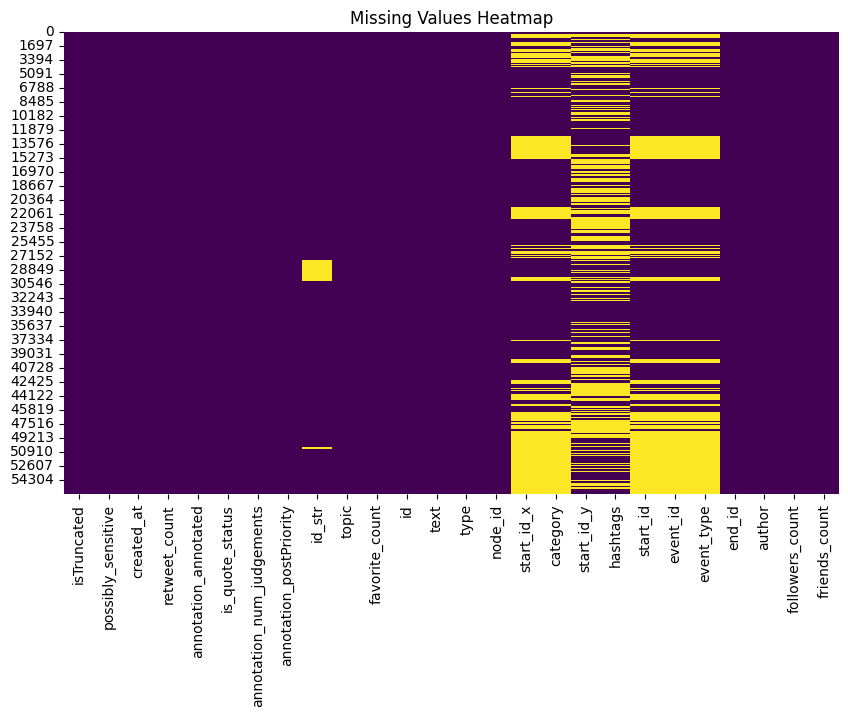

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap des NaNs
plt.figure(figsize=(10, 6))
sns.heatmap(tweets.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

In [13]:
tweets['event_id'].value_counts()

event_id
nepalEarthquake2015              5858
typhoonHagupit2014               3938
fireYMM2016                      2498
shootingDallas2017               2498
albertaWildfires2019             2340
cycloneKenneth2019               2073
parisAttacks2015                 2064
hurricaneFlorence2018            1998
philippinesEarthquake2019        1997
southAfricaFloods2019            1345
coloradoStemShooting2019         1146
flSchoolShooting2018             1117
albertaFloods2013                 722
queenslandFloods2013              713
australiaBushfire2013             677
sandiegoSynagogueShooting2019     636
earthquakeBohol2013               583
typhoonYolanda2013                564
bostonBombings2013                535
philipinnesFloods2012             437
manilaFloods2013                  411
floodChoco2019                    389
chileEarthquake2014               311
fireColorado2012                  263
costaRicaEarthquake2012           247
typhoonPablo2012                  244
flo

In [14]:
from data_loader import load_and_preprocess_with_embeddings

test = load_and_preprocess_with_embeddings()
test.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sigurd.saue/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sigurd.saue/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,isTruncated,possibly_sensitive,created_at,retweet_count,annotation_annotated,is_quote_status,annotation_num_judgements,annotation_postPriority,id_str,topic,favorite_count,id_x,text,id_y,eventType,trecisid,timestamp,clean_text,tokens,tweet_embedding
0,False,False,2012-06-09T00:00Z,0,True,False,3,Low,211281973870727170,TRECIS-CTIT-H-001,1,211281973870727170,#colorado. Told you its #amazing http://t.co/6...,fireColorado2012,wildfire,TRECIS-CTIT-H-001,2012-06-09 00:00:00+00:00,told,[told],"[-0.019290950149297714, 0.11544579267501831, 0..."
1,False,False,2012-06-09T00:00Z,3,True,False,1,Medium,211557401231495171,TRECIS-CTIT-H-001,0,211557401231495171,RT @northfortynews: Tanker helicopter heads up...,fireColorado2012,wildfire,TRECIS-CTIT-H-001,2012-06-09 00:00:00+00:00,rt tanker helicopter heads paradise park drop ...,"[rt, tanker, helicopter, heads, paradise, park...","[-0.005831373855471611, 0.08073563128709793, -..."
2,False,True,2012-06-09T00:00Z,2,True,False,1,High,211565974422425600,TRECIS-CTIT-H-001,0,211565974422425600,#Evacuation center Cache La Poudre Middle Scho...,fireColorado2012,wildfire,TRECIS-CTIT-H-001,2012-06-09 00:00:00+00:00,center cache la poudre middle school west coun...,"[center, cache, la, poudre, middle, school, we...","[0.0069395191967487335, 0.0070179058238863945,..."
3,False,True,2012-06-09T00:00Z,0,True,False,1,Medium,211607187653533697,TRECIS-CTIT-H-001,0,211607187653533697,20F degrees cooler tomorrow in North Central &...,fireColorado2012,wildfire,TRECIS-CTIT-H-001,2012-06-09 00:00:00+00:00,f degrees cooler tomorrow north central amp no...,"[f, degrees, cooler, tomorrow, north, central,...","[-0.015826473012566566, -0.007906593382358551,..."
4,False,False,2012-06-10T00:00Z,0,True,False,1,Medium,211654415503990784,TRECIS-CTIT-H-001,0,211654415503990784,FEMA has authorized the use of federal funds t...,fireColorado2012,wildfire,TRECIS-CTIT-H-001,2012-06-10 00:00:00+00:00,fema authorized use federal funds help firefig...,"[fema, authorized, use, federal, funds, help, ...","[0.07331261038780212, 0.08005324006080627, -0...."


In [23]:
tweets['tweet_embedding'] = test['tweet_embedding']

In [24]:
tweets

,isTruncated,possibly_sensitive,created_at,retweet_count,annotation_annotated,is_quote_status,annotation_num_judgements,annotation_postPriority,id_str,topic,...,start_id_y,hashtags,start_id,event_id,event_type,end_id,author,followers_count,friends_count,tweet_embedding
0,False,False,2012-06-09T00:00Z,0,True,False,3,Low,211281973870727170,TRECIS-CTIT-H-001,...,582,"[amazing, colorado]",582,fireColorado2012,wildfire,582,jeffseroka,537,400,"[-0.019290950149297714, 0.11544579267501831, 0..."
1,False,False,2012-06-09T00:00Z,3,True,False,1,Medium,211557401231495171,TRECIS-CTIT-H-001,...,583,[HighParkFire],583,fireColorado2012,wildfire,583,mpf2011,4740,4930,"[-0.005831373855471611, 0.08073563128709793, -..."
2,False,True,2012-06-09T00:00Z,2,True,False,1,High,211565974422425600,TRECIS-CTIT-H-001,...,584,"[Colorado, Evacuation, Wildfire]",584,fireColorado2012,wildfire,584,SF_AngelaThorpe,2684,4726,"[0.0069395191967487335, 0.0070179058238863945,..."
3,False,True,2012-06-09T00:00Z,0,True,False,1,Medium,211607187653533697,TRECIS-CTIT-H-001,...,585,"[Colorado, Heat, HighParkFire, COwx, Coolbreak]",585,fireColorado2012,wildfire,585,WilliamScherer3,113859,104963,"[-0.015826473012566566, -0.007906593382358551,..."
4,False,False,2012-06-10T00:00Z,0,True,False,1,Medium,211654415503990784,TRECIS-CTIT-H-001,...,586,[HighParkFire],586,fireColorado2012,wildfire,586,sherivf,1624,1849,"[0.07331261038780212, 0.08005324006080627, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55981,False,True,2016-05-03T00:00Z,6,False,False,0,Unknown,727640827128741888,TRECIS-CTIT-H-028,...,56563,"[ymmfire, ymm, yvr, yeg, yyc]",NaN,NaN,NaN,56563,lilmissElaine,336,133,"[0.004615095444023609, -0.010219406336545944, ..."
55982,False,False,2016-05-03T00:00Z,1,False,True,0,Unknown,727641239009558528,TRECIS-CTIT-H-028,...,56564,"[FortMcMurray, YMMfire, FortMac]",NaN,NaN,NaN,56564,stephenkent,12868,10665,"[-0.01643691211938858, 0.005710536148399115, -..."
55983,False,True,2016-05-03T00:00Z,10,False,False,0,Unknown,727642861026562048,TRECIS-CTIT-H-028,...,56565,"[PEI, ymmfire]",NaN,NaN,NaN,56565,jsjaylward,2640,1152,"[0.015418076887726784, 0.02889014594256878, 0...."
55984,False,True,2016-05-03T00:00Z,9,False,False,0,Unknown,727643106049282048,TRECIS-CTIT-H-028,...,56566,"[FortMcMurray, ymm, yeg, ymmfire]",NaN,NaN,NaN,56566,FlyEIA,29778,31337,"[-0.0006967700319364667, 0.02492540515959263, ..."


In [ ]:
tweets.drop(columns=['id_str', 'id', 'text', 'type', 'node_id', 'start_id_x', 'start_id_y', 'start'], inplace=True)

In [26]:
tweets

,isTruncated,possibly_sensitive,created_at,retweet_count,annotation_annotated,is_quote_status,annotation_num_judgements,annotation_postPriority,topic,favorite_count,category,hashtags,start_id,event_id,event_type,end_id,author,followers_count,friends_count,tweet_embedding
0,False,False,2012-06-09T00:00Z,0,True,False,3,Low,TRECIS-CTIT-H-001,1,Irrelevant,"[amazing, colorado]",582,fireColorado2012,wildfire,582,jeffseroka,537,400,"[-0.019290950149297714, 0.11544579267501831, 0..."
1,False,False,2012-06-09T00:00Z,3,True,False,1,Medium,TRECIS-CTIT-H-001,0,FirstPartyObservation,[HighParkFire],583,fireColorado2012,wildfire,583,mpf2011,4740,4930,"[-0.005831373855471611, 0.08073563128709793, -..."
2,False,True,2012-06-09T00:00Z,2,True,False,1,High,TRECIS-CTIT-H-001,0,ServiceAvailable,"[Colorado, Evacuation, Wildfire]",584,fireColorado2012,wildfire,584,SF_AngelaThorpe,2684,4726,"[0.0069395191967487335, 0.0070179058238863945,..."
3,False,True,2012-06-09T00:00Z,0,True,False,1,Medium,TRECIS-CTIT-H-001,0,Weather,"[Colorado, Heat, HighParkFire, COwx, Coolbreak]",585,fireColorado2012,wildfire,585,WilliamScherer3,113859,104963,"[-0.015826473012566566, -0.007906593382358551,..."
4,False,False,2012-06-10T00:00Z,0,True,False,1,Medium,TRECIS-CTIT-H-001,0,News,[HighParkFire],586,fireColorado2012,wildfire,586,sherivf,1624,1849,"[0.07331261038780212, 0.08005324006080627, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55981,False,True,2016-05-03T00:00Z,6,False,False,0,Unknown,TRECIS-CTIT-H-028,7,NaN,"[ymmfire, ymm, yvr, yeg, yyc]",NaN,NaN,NaN,56563,lilmissElaine,336,133,"[0.004615095444023609, -0.010219406336545944, ..."
55982,False,False,2016-05-03T00:00Z,1,False,True,0,Unknown,TRECIS-CTIT-H-028,0,NaN,"[FortMcMurray, YMMfire, FortMac]",NaN,NaN,NaN,56564,stephenkent,12868,10665,"[-0.01643691211938858, 0.005710536148399115, -..."
55983,False,True,2016-05-03T00:00Z,10,False,False,0,Unknown,TRECIS-CTIT-H-028,13,NaN,"[PEI, ymmfire]",NaN,NaN,NaN,56565,jsjaylward,2640,1152,"[0.015418076887726784, 0.02889014594256878, 0...."
55984,False,True,2016-05-03T00:00Z,9,False,False,0,Unknown,TRECIS-CTIT-H-028,19,NaN,"[FortMcMurray, ymm, yeg, ymmfire]",NaN,NaN,NaN,56566,FlyEIA,29778,31337,"[-0.0006967700319364667, 0.02492540515959263, ..."
